## Using ML to Predict Bioactivity of Drugs

**Analysis for coronavirus drug data retrieved from [*ChEMBL Database*](https://www.ebi.ac.uk/chembl/)**

Submitted by

- Kuldeep Singh 16235


### Installing library which will be used to retreive data

In [3]:
try:
    import chembl_webresource_client
    from chembl_webresource_client.new_client import new_client
except:
    !pip install chembl_webresource_client
    import chembl_webresource_client
    from chembl_webresource_client.new_client import new_client

     |████████████████████████████████| 61kB 2.1MB/s 
  Created wheel for chembl-webresource-client: filename=chembl_webresource_client-0.10.2-cp36-none-any.whl size=55662 sha256=fbd53bd2c3130c8e3277137ccf54f91f7e8339377be6162600edca2552360c29
  Stored in directory: /root/.cache/pip/wheels/e6/96/19/3f042bfda7c669bfe24c8278477f57b0fbbf3e488b4c09e3a8
Successfully built chembl-webresource-client


In [4]:
import pandas as pd

#### retrieving target based data

In [5]:
target = new_client.target
target_query = target.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,14.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,14.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,5.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859


### Will be using *SARS coronavirus 3C-like proteinase* Bioactivity Data

In [6]:
selected_target = targets.target_chembl_id[4]
selected_target

'CHEMBL3927'

In [7]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [8]:
data = pd.DataFrame.from_dict(res)
data.columns

Index(['activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')

In [9]:
data.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '18.28', 'le': '0.33', 'lle': '3.25', ...",CHEMBL187579,None,CHEMBL187579,5.14,False,http://www.openphacts.org/units/Nanomolar,384103,=,1,True,=,None,IC50,nM,None,7200.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '12.10', 'le': '0.33', 'lle': '1.22', ...",CHEMBL188487,None,CHEMBL188487,5.03,False,http://www.openphacts.org/units/Nanomolar,383984,=,1,True,=,None,IC50,nM,None,9400.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '11.56', 'le': '0.29', 'lle': '2.21', ...",CHEMBL185698,None,CHEMBL185698,4.87,False,http://www.openphacts.org/units/Nanomolar,384106,=,1,True,=,None,IC50,nM,None,13500.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.64', 'le': '0.32', 'lle': '1.25', ...",CHEMBL426082,None,CHEMBL426082,4.88,False,http://www.openphacts.org/units/Nanomolar,384075,=,1,True,=,None,IC50,nM,None,13110.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,BAO_0000190,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,"{'bei': '16.84', 'le': '0.32', 'lle': '2.16', ...",CHEMBL187717,None,CHEMBL187717,5.70,False,http://www.openphacts.org/units/Nanomolar,384234,=,1,True,=,None,IC50,nM,None,2000.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0


In [10]:
data_1 = data[data.standard_value.notna()] #removing unavailable data
data.shape

(133, 43)

## Preprocesssing

### **Labeling compounds as either being active, inactive or intermediate**
The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**.

In [11]:
bioactivity_class = []
for i in data_1.standard_value:
  if float(i) >= 10000:
    bioactivity_class.append("inactive")
  elif float(i) <= 1000:
    bioactivity_class.append("active")
  else:
    bioactivity_class.append("intermediate")

In [12]:
# USING ONLY RELEVANT COLUMNS TO US
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
data_2 = data_1[selection]
data_3 = pd.concat([data_2,pd.Series(bioactivity_class)], axis=1)
data_3.rename(columns={0:'Bio_class'},inplace=True)
data_3.head()

,molecule_chembl_id,canonical_smiles,standard_value,Bio_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate


### Downloading other Liberaries to create descriptors for Data analysis

In [17]:
# uncomment this if You are running in colab. It is for rdkit installation on google colab.
#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
#! conda install -c rdkit rdkit -y
#import sys
#sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [22]:
# This was to check whether we have desired csv present in directory or not.
#import os
#os.getcwd()
#os.chdir('Colab Notebooks')
#os.listdir()

In [23]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [24]:
# code used from dataprof 
def descriptors(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        # other descriptors are not relatable for Bioactivity predictions, SO 
        # sticking with default 4 of these.

           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [25]:
data_desc = descriptors(data_3.canonical_smiles)
data_desc.head()

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0


In [27]:
data_combined = pd.concat([data_3,data_desc], axis = 1)
data_combined.head()

,molecule_chembl_id,canonical_smiles,standard_value,Bio_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate,338.344,3.53900,0.0,5.0


### Converting standard_value IC$_{50}$ (have nM-nanoMolar unit) to Logrithmic pIC$_{50}$. 

In [28]:
data_combined['standard_value'] = data_combined['standard_value'].astype(float)
data_combined.standard_value.describe()

count    1.330000e+02
mean     8.017926e+12
std      3.344888e+13
min      5.000000e+01
25%      1.070000e+04
50%      2.350000e+04
75%      3.000000e+05
max      3.311311e+14
Name: standard_value, dtype: float64

In [29]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9)             # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

Since moles can't be negative, values more than 100 million are capped to 100 million

In [30]:
data_normed = norm_value(data_combined)
data_final = pIC50(data_normed)
for i in data_final.pIC50:
    if i<0:
        print(i)
data_final.head()

,molecule_chembl_id,canonical_smiles,Bio_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970


We don't want logrithmic negative values therefore capping the max of IC50 data to 100 million

In [31]:
data_final.to_csv('data_final.csv',index=False)
#data_final = pIC50(df_norm)
#data_final.head()

In [32]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

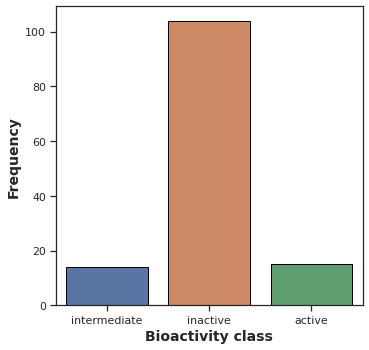

In [33]:
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='Bio_class', data=data_final, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
#plt.savefig('plot_bioactivity_class.png')

### Scatter plot below

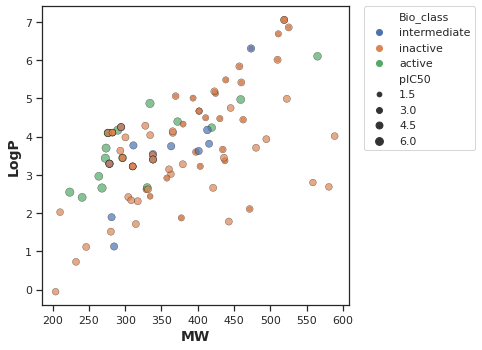

In [34]:
plt.figure(figsize=(5.5, 5.5))
sns.scatterplot(x='MW', y='LogP', data=data_final, hue='Bio_class', size='pIC50', edgecolor='black', alpha=0.7)
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#plt.savefig('plot_MW_vs_LogP.png')

### pIC50 box Plot

Text(0, 0.5, 'pIC50 value')

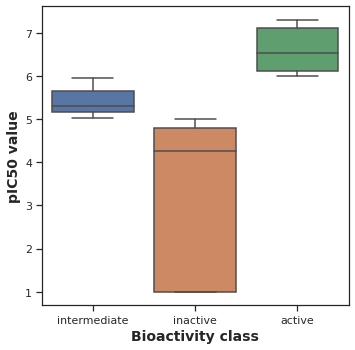

In [35]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'Bio_class', y = 'pIC50', data = data_final)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
#plt.savefig('plot_ic50.png')

### Comparing Active and Inactive Biactivity levels. 
To see these two groups are different statistically or not using ***Man-whiteny U test***

In [36]:
data_2class = data_final[data_final.Bio_class!= 'intermediate']
data_2class.shape

(119, 8)

#### Statistical analysis | Man-whiteny U test
~~~
This test is used to analyze whether two groups are related or not. Inspired from dataprof.


In [43]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'Bio_class']
  df = data_2class[selection]
  active = df[df.Bio_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'Bio_class']
  df = data_2class[selection]
  inactive = df[df.Bio_class == 'inactive']
  inactive = inactive[descriptor]

  selection = [descriptor, 'Bio_class']
  df = data_final[selection]
  intermediate = df[df.Bio_class == 'intermediate']
  intermediate = intermediate[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  
  return results

In [44]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.662636e-10,0.05,Different distribution (reject H0)


#### MW

Text(0, 0.5, 'MW')

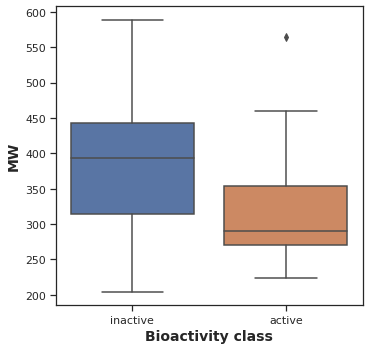

In [45]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'Bio_class', y = 'MW', data = data_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')
#plt.savefig('plot_MW_ic50.png')

In [46]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,409.5,0.001525,0.05,Different distribution (reject H0)


Text(0, 0.5, 'LogP')

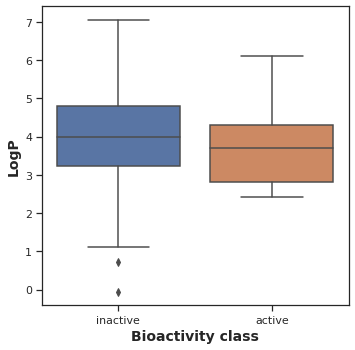

In [47]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'Bio_class', y = 'LogP', data = data_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
#plt.savefig('plot_LogP_IC50.png')

In [48]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,712.5,0.295805,0.05,Same distribution (fail to reject H0)


Text(0, 0.5, 'NumHDonors')

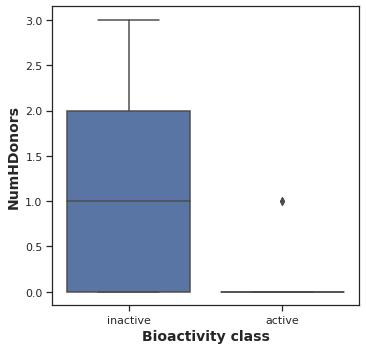

In [49]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'Bio_class', y = 'NumHDonors', data = data_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')
#plt.savefig('plot_NumHDonors_IC50.png')

In [50]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,299.5,0.000024,0.05,Different distribution (reject H0)


Text(0, 0.5, 'NumHAcceptors')

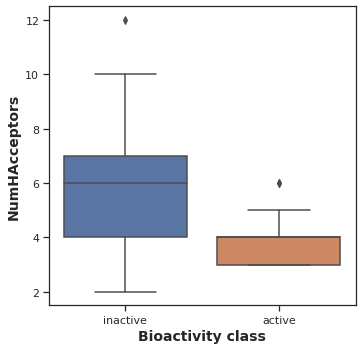

In [51]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'Bio_class', y = 'NumHAcceptors', data = data_2class)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')
#plt.savefig('plot_NumHAcceptors_IC50.png')

In [52]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,415.0,0.001557,0.05,Different distribution (reject H0)


#### Interpretation of Results From Box Plots
**pIC50 values**

Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since threshold values 
  (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

**Lipinski Descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only **LogP** exhibited no difference between the actives and inactives while the other 3 descriptors **(MW, NumHDonors and NumHAcceptors)** shows statistically significant difference between actives and inactives.

## Using Descriptor generator
This piece of code is taken from [dataprof](https://www.youtube.com/watch?v=zD2focOkQ48).

In [53]:
if 'padel.sh' in os.listdir():
    pass
else:
    ! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
    ! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2020-10-12 16:18:35--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2020-10-12 16:18:35--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  49.5MB/s    in 0.5s    

2020-10-12 16:18:36 (49.5 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2020-10-12 16:18:36--  https://github.com

In [54]:
if 'PaDEL-Descriptor' in os.listdir():
    pass
else:
    ! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [55]:
selection = ['canonical_smiles','molecule_chembl_id']
data_selection = data_final[selection]
data_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [56]:
! cat molecule.smi | head -5  #this code won't word on jupyter offline

Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21	CHEMBL187579
O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21	CHEMBL188487
O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21	CHEMBL185698
O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21	CHEMBL426082
O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-]	CHEMBL187717


In [57]:
! cat molecule.smi | wc -l

133


### Calculate PaDEL fingerprints

In [58]:
! bash padel.sh

Processing CHEMBL187579 in molecule.smi (1/133). 
Processing CHEMBL188487 in molecule.smi (2/133). 
Processing CHEMBL185698 in molecule.smi (3/133). Average speed: 2.27 s/mol.
Processing CHEMBL426082 in molecule.smi (4/133). Average speed: 1.15 s/mol.
Processing CHEMBL365134 in molecule.smi (6/133). Average speed: 0.82 s/mol.
Processing CHEMBL187717 in molecule.smi (5/133). Average speed: 0.99 s/mol.
Processing CHEMBL187598 in molecule.smi (7/133). Average speed: 0.75 s/mol.
Processing CHEMBL190743 in molecule.smi (8/133). Average speed: 0.71 s/mol.
Processing CHEMBL365469 in molecule.smi (9/133). Average speed: 0.63 s/mol.
Processing CHEMBL191575 in molecule.smi (11/133). Average speed: 0.56 s/mol.
Processing CHEMBL188983 in molecule.smi (10/133). Average speed: 0.62 s/mol.
Processing CHEMBL194398 in molecule.smi (13/133). Average speed: 0.57 s/mol.
Processing CHEMBL370923 in molecule.smi (12/133). Average speed: 0.57 s/mol.
Processing CHEMBL196635 in molecule.smi (14/133). Average sp

### Preparing X and Y Matrices

In [59]:
data_X = pd.read_csv('descriptors_output.csv')
data_X = data_X.drop(columns=['Name'])
data_X.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
data_Y = data_final['pIC50']
data_Y

0      5.142668
1      5.026872
2      4.869666
3      4.882397
4      5.698970
         ...   
128    4.974694
129    4.995679
130    4.939302
131    4.970616
132    4.102923
Name: pIC50, Length: 133, dtype: float64

In [61]:
final_dataset = pd.concat([data_X,data_Y], axis=1)
final_dataset.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.142668
1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.026872
2,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.869666
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.882397
4,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.698970


In [62]:
final_dataset.to_csv('Final_dataset.csv', index=False)

## Training Model
Now we have our cleaned and preprocessed data. So we will train few models and use the best performing one.

Input and output features

In [63]:
X,Y = data_X, data_Y
X.shape, Y.shape

((133, 881), (133,))

In [64]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor 

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((106, 881), (106,), (27, 881), (27,))

In [66]:
classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression(),
    RandomForestRegressor()]

for item in classifiers:
    #print(item,'\n')
    clf = item
    clf.fit(X_train, Y_train)
    #print(clf.predict(X_test),'\n')
    print(f" r2 score of {str(item).split('(')[0]} is {clf.score(X_test, Y_test):.4} \n")

 r2 score of SVR is 0.2464 

 r2 score of SGDRegressor is 0.1369 

 r2 score of BayesianRidge is 0.3175 

 r2 score of LassoLars is -0.06408 

 r2 score of ARDRegression is 0.0175 

 r2 score of PassiveAggressiveRegressor is -0.1793 

 r2 score of TheilSenRegressor is -0.6508 

 r2 score of LinearRegression is -2.684e+17 

 r2 score of RandomForestRegressor is 0.005313 



From above testing it is clear that [**BayesianRidge**](https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html#bayesian-ridge-regression) method is having highest score, although it is also not good.

In [67]:
clf = linear_model.BayesianRidge()
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

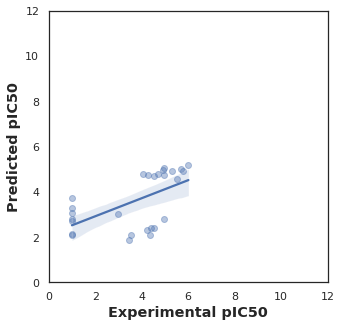

In [68]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

I have checked descriptors using rdkit also which gives less rscore as compared to using bash file provided by data prof.